# Introduction

Light Gradient Boosting Machine, is a free and open source distributed gradient boosting framework for machine learning originally developed by Microsoft.
Fast, distributed, high-performance gradient boosting framework based on decision tree algorithm.

Gradient boosted decision trees is an ensemble model of decision trees. 

It is based on three important principles:

1. Weak learners (decision trees).
2. Gradient Optimization.
3. Boosting Technique.

In the gbdt method we have a lot of decision trees(weak learners). Those trees are built sequentially:

first tree learns how to fit to the target variable
second tree learns how to fit to the residual (difference) between the predictions of the first tree and the ground truth
The third tree learns how to fit the residuals of the second tree and so on.
All those trees are trained by propagating the gradients of errors throughout the system.

The approach for this notebook is to sample the trainset using a range of time ids and do an initial model training to identify the most important features.

These selected features will then be subset to train the main model.

Metrics tracked from the full feature model and subset feature model will be compared.

This notebook is made up of the following sections:

1. Importing libraries
2. Data importation
3. Data wrangling
4. Model training on full feature set
5. Model training with select features
6. Api Submission
7. Evaluation


## 1. Import Libraries

This section imports all the necessary libraries for data importation, wrangling, visualization and modeling.


In [1]:
import pandas as pd                                     # Data manipulation
import numpy as np                                      # Mathematical functions
import gc                                               # Automatically releases memory when an object is no longer used
import lightgbm as lgb                                  # High performance gradient boosting framework
import time                                             # Representing time in code
from sklearn.metrics import mean_squared_error          # Function for calculating MSE metric
import scipy                                            # Scientific computing and technical computing
from scipy.stats import pearsonr                        # Calculationg pearson correlation coefficient
import matplotlib.pyplot as plt                         # Plotting
import pickle                                           # Serializing object structures


In [2]:
## Remove scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. Data Importation

This competition's dataset (18.55 GB) is too large. We will use another dataset converted to utilize less memory in pickle format. The dataset is in pickle format and utilizes less memory.

In [3]:
## Import training data
## A memory optimized pickle dataset will be utilized.

df_train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')

## 3. Data Wrangling

In [4]:
## Glimpse dataset
df_train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.93,0.11,-0.40,0.38,-0.20,-0.41,0.97,1.23,...,-1.10,0.20,0.82,0.94,-0.09,-1.09,-1.04,-0.29,0.32,-0.30
1,2,0,0.81,-0.51,0.74,-0.62,-0.19,1.77,1.43,1.13,...,0.91,-0.73,0.82,0.94,-0.39,-1.09,-0.93,-0.97,-0.34,-0.23
2,6,0,0.39,0.62,0.57,-0.61,0.07,-1.08,0.98,-1.13,...,0.91,-0.55,-1.22,-1.06,-0.22,-1.09,-0.61,-0.11,0.24,0.57
3,7,0,-2.34,-0.01,1.88,-0.61,-0.59,-0.82,0.78,0.30,...,0.91,-0.27,-1.22,0.94,-0.61,0.10,-0.78,1.15,-0.77,-1.06
4,8,0,0.84,-0.26,2.33,-0.58,-0.62,-0.74,-0.95,1.23,...,0.91,-0.74,-1.22,0.94,-0.59,0.10,0.75,1.35,-0.74,-0.53


In [5]:
## Number of investments
df_train.investment_id.nunique()

3579

In [6]:
## Number of Time ids
df_train.time_id.nunique()

1211

In [7]:
## Target feature distribution

df_train.target.describe()

count   3141410.00
mean           NaN
std           0.00
min          -9.42
25%          -0.50
50%          -0.10
75%           0.36
max          12.04
Name: target, dtype: float64

Data for the trainset will be sampled as follows:

1. trainset : time id 500 to time id 999
2. testset : time id greater or equal to 1000


In [8]:
## Sample investments with at least time_id 500
first_time_id_to_use = 500 

## Select anonymized features
features_to_use= [col for col in df_train.columns if col.startswith("f")] # use only the anonymised features

## Cap training set at time id 1000
time_id_to_split_train_and_val = 1000

## Filter for investments greater than time period
df_train = df_train.loc[df_train.time_id >= first_time_id_to_use]
print("df_train.shape: ",df_train.shape)

## Split data into train and validation set
X_train = df_train.loc[df_train.time_id < time_id_to_split_train_and_val]
X_val = df_train.loc[df_train.time_id >= time_id_to_split_train_and_val]

## Select target features
y_train = X_train.target
y_val = X_val.target

## Select independent features (anonymalized)
X_train = X_train[features_to_use]
X_val = X_val[features_to_use]

print("X_train.shape:  ", X_train.shape)
print("X_val.shape:    ", X_val.shape)

df_train.shape:  (2081209, 303)
X_train.shape:   (1373071, 300)
X_val.shape:     (708138, 300)


## 4. Model Training on Full Feature Set

The model will be first trained on full set of features to identify most important features. The final model will then be trained on a subset of the identified features.

* The datasets will be converted to light GBM data containers before training.
* Initial model training on sample set will be conducted to identify the most important features.

In [9]:
## create lgbm containers
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

Defining model parameters to train initial model.

In [10]:
## Define parameters

lgb_params = {'objective': 'regression', ## max number of leaves in one tree.
    'metric': 'MSE', ## Mean Squared Error to be evaluated on the evaluation set.
    'boosting_type': 'gbdt', ## traditional Gradient Boosting Decision Tree
    'lambda_l1': 2.3e-05, ## combat overfitting
    'lambda_l2': 0.1, ## combat overfitting
    'num_leaves': 4, ## set the maximum number of leaves each weak learner has
    'feature_fraction': 0.5, ## randomly select a subset of features on each iteration (tree) for training.
    'bagging_fraction': 0.9, ## randomly select part of data without resampling
    'bagging_freq': 7, ## frequency for bagging
    'min_child_samples': 20, ## Minimum number of data points needed in a child (leaf) node.
    'num_iterations': 1000 ## controls the number of boosting rounds that will be performed (number of trees)
             }

In [11]:
ts = time.time()

# dict for logging the evaluation metrics
metric_over_time = {} 

## Train model
model = lgb.train(        
        lgb_params, 
        dtrain, 
        valid_sets=[dtrain, dval],
        valid_names=['train','val'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100), lgb.record_evaluation(metric_over_time)]
    )


execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.524074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1373071, number of used features: 300
[LightGBM] [Info] Start training from score -0.015203
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 0.851083	val's l2: 0.807418
[200]	train's l2: 0.847138	val's l2: 0.806315
[300]	train's l2: 0.84416	val's l2: 0.805887
[400]	train's l2: 0.84167	val's l2: 0.805614
[500]	train's l2: 0.839433	val's l2: 0.805535
Early stopping, best iteration is:
[461]	train's l2: 0.840304	val's l2: 0.805501

Training time: 384.294s


We will evaluate model perfomance initial model using mean squared error (MSE) and root mean squared error (RMSE) metrics. 

These metrics will be compared to the main model metrics to gauge if reducing the number of features will impact the model.

In [12]:

# Make predictions on sample test set
y_val_hat = model.predict(X_val)

# Print sample model metrics
print("MSE:  ", mean_squared_error(y_val, y_val_hat, squared=True))
print("RMSE: ", mean_squared_error(y_val, y_val_hat, squared=False))

MSE:   0.8055005324507704
RMSE:  0.8974968147301529


We will run correlation analysis to measure relationship between predicted and actual values.

In [13]:
# check the competition metric 
# correlation between predicted and actual
corr, _ = pearsonr(y_val_hat, y_val)
print("Pearson Correlation Coeficient Validation Data: ", corr)

Pearson Correlation Coeficient Validation Data:  0.12600954147083407


Visualization of error metric during training.

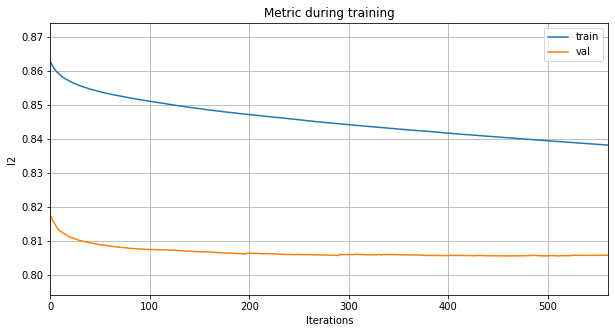

In [14]:
## Plot metric (MSE)
lgb.plot_metric(metric_over_time, figsize=(10,5))
plt.show()

A plot of feature importance is used to visualize how a feature impacts the model relative to other features.

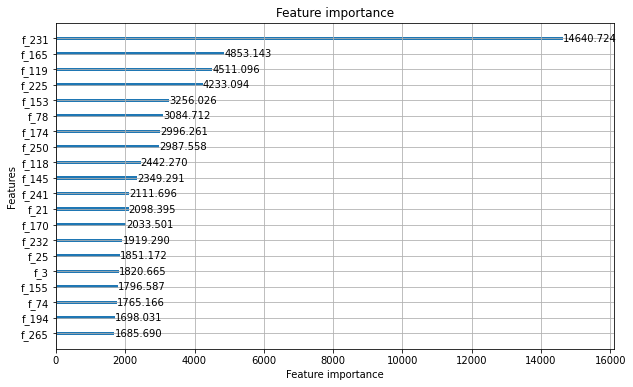

In [15]:
# let's look at which features lgbm deems important
## We will plot top 20
lgb.plot_importance(model, figsize=(10,6), importance_type='gain', max_num_features=20) # importance_type: gain/split: V7 has 'split'
plt.show()

Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

In [16]:
# there are features with little importance, get rid of them
imp = pd.DataFrame({'Value':model.feature_importance(importance_type='gain'),'Feature':X_train.columns}).sort_values(by="Value",ascending=False).reset_index(drop=True)
print(imp.head())
print("")
print("Value Distribution")
print(imp.Value.describe())


     Value Feature
0 14640.72   f_231
1  4853.14   f_165
2  4511.10   f_119
3  4233.09   f_225
4  3256.03   f_153

Value Distribution
count     300.00
mean      516.25
std      1082.89
min         0.00
25%        53.56
50%       187.17
75%       598.26
max     14640.72
Name: Value, dtype: float64


Features with gain greater than 100 will be subset to train the main model.

In [17]:
#imp.Value.value_counts()
imp = imp[imp.Value>100]  # remove all features with gain lower than 100
new_feature_list = list(imp.Feature)
print("Number of features, new: ", len(new_feature_list))

Number of features, new:  188


In [18]:
# save model to disk, it will take up approx. 263kB
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Free up memory before main model training.

In [19]:
del model,y_val_hat,dtrain,dval,imp # free up memory


## 5. Model Training on Selected Features

Filter for subset of selected features and convert the data to light GBM data containers for training and test sets.

In [20]:
## Now it's time to retrain with the reduced feature set.

dtrain = lgb.Dataset(X_train[new_feature_list], label=y_train)
dval = lgb.Dataset(X_val[new_feature_list], label=y_val)


Train the data on selected subset of features.

In [21]:

# Cell start time
ts = time.time()

## Run model with early stopping
model = lgb.train(        
        lgb_params, 
        dtrain, 
        valid_sets=[dtrain, dval],
        valid_names=['train','val'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100), lgb.record_evaluation(metric_over_time)]
    )


## Cell completion time
execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.240026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47940
[LightGBM] [Info] Number of data points in the train set: 1373071, number of used features: 188
[LightGBM] [Info] Start training from score -0.015203
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 0.851056	val's l2: 0.807663
[200]	train's l2: 0.847204	val's l2: 0.80627
[300]	train's l2: 0.844254	val's l2: 0.805558
[400]	train's l2: 0.841698	val's l2: 0.805341
[500]	train's l2: 0.839565	val's l2: 0.805905
Early stopping, best iteration is:
[430]	train's l2: 0.84108	val's l2: 0.80524

Training time: 239.043s


Make predictions on test set.

In [22]:
# Predictions
y_val_hat = model.predict(X_val[new_feature_list])

# using MSE as a proxy for pearson corellation (https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302181)
print("MSE:  ", mean_squared_error(y_val, y_val_hat, squared=True))
print("RMSE: ", mean_squared_error(y_val, y_val_hat, squared=False))

MSE:   0.8052403598855596
RMSE:  0.8973518595765875


In [23]:
corr, _ = pearsonr(y_val_hat, y_val)
print("Pearson Correlation Coeficient Validation Data: ", corr)

Pearson Correlation Coeficient Validation Data:  0.1272356237253427


In [24]:
# save model to disk, it will take up approx. 205kB
filename = 'finalized_model_reduced.sav'
pickle.dump(model, open(filename, 'wb'))

## 6. API Submission

This section preprocesses the test set from the API and makes predictions from the trained model.

In [25]:
def preprocess(df, features):
    
    
    """ Function to select features from a given dataset. 

    Parameters
    ----------
    
    df: dataframe to be subset
    
    features: A list of features to be selected from dataframe

    
    Returns
    -------
    df : A filtered dataframe with list of features specified.
    
    """
    
    df = df[features]  
    return df
    
def make_predictions(model, df): 
    
        
    """ Function to make predictions on a given dataset. 

    Parameters
    ----------
    
    model: A pre-trained model.
    
    df: Dataframe with independent features for prediction.

    
    Returns
    -------
    pred : An array of predicted values for the data points
    
    """
    pred = model.predict(df)
    return pred

Call Kaggle API for test_set serving.

In [26]:
import ubiquant
env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    test_df = preprocess(test_df, new_feature_list) 
    sample_prediction_df['target'] = make_predictions(model, test_df)  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


## 8. Evaluation

There seems to be a small but not significant improvement in model importance between the model with full feature set and model with fewer features (188) as can be seen in the table below.

|Model| |Independent-Features||MAE| |MSE| |Pearson-corr|
|-----| |--------------------||---| |---| |------------|
|300 Feature Model| |300||0.8055||0.8975||0.1260|
|188 Feature Model| |188||0.8052||0.8973||0.1272|

**The model resulted in a submission score of 0.108 on kaggle**

# Conclusion

The multi input neural network model has a higher perfomance hence more time will be spent developing it